In [1]:
import torch 
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np

Text(0.5, 1.0, 'data distribution')

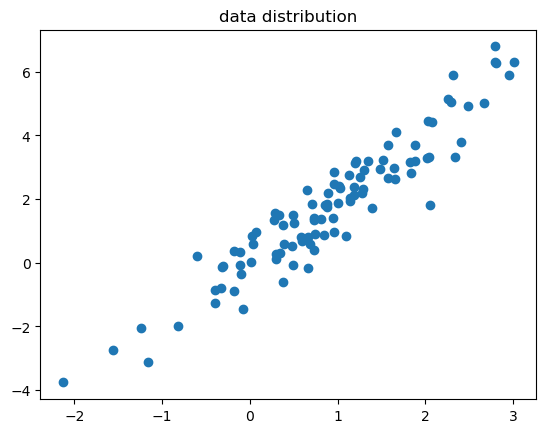

In [15]:
"""
Sample data of a shifted Gaussian with mean b and covariance A.T A 
"""
# Generate random data 
X = torch.normal(0.0, 1, (2000,2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])

# Affine input 

data = torch.matmul(X, A ) + b

plt.scatter(data[:100, 0].detach().numpy(), data[:100, 1].detach().numpy())
plt.title("input data distribution")

In [16]:
class TrainData(Dataset):
    def __init__(self, X):
        self.X = X 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index]

train_data = TrainData(data)
train_dataloader = DataLoader(train_data, batch_size=16, shuffle= True)

In [17]:
# Generator 
net_G = nn.Sequential(nn.Linear(2,2))

# Discriminator 
net_D = nn.Sequential(nn.Linear(2,5), nn.Tanh(),
        nn.Linear(5,3), nn.Tanh(), 
        nn.Linear(3,1), nn.Tanh())
        

In [18]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):

    batch_size = X.shape[0]
    
    # Labels assignment 
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    
    
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)

    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
    loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()

    return loss_D

In [19]:
def update_G(Z, net_D, net_G, loss, trainer_G):
 
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

In [22]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    loss_lstgen, loss_lstdes = [], []
    for epoch in range(0,num_epochs+1):
        loss_D, loss_G = 0, 0 
      
        for i, (X) in enumerate(data_iter):
            # Latent variable 
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            loss_D += update_D(X, Z, net_D, net_G, loss, trainer_D)
            loss_G += update_G(Z, net_D, net_G, loss, trainer_G)
        print("Epoch : {}  | D loss : {} | G loss : {}|".format(epoch, loss_D/batch_size, loss_G/batch_size))
        loss_lstgen.append(loss_G.detach().numpy()/batch_size)
        loss_lstdes.append(loss_D.detach().numpy()/batch_size)

    print("Generated Data vs Input Data Distribution")

    # Inference 
    Z = torch.normal(0, 1, size=(100, latent_dim))
    fake_X = net_G(Z).detach().numpy()
    plt.figure()
    plt.scatter(data[:, 0], data[:, 1], label = "Real")
    plt.scatter(fake_X[:,0], fake_X[:,1], label = "Generated")
    plt.legend()
    plt.xlabel("X coord")
    plt.ylabel("Y coord")
    plt.grid(True)
    plt.show()
   

    print("Generator vs Discriminator loss")
    plt.figure()
    temp = np.arange(0,len(loss_lstgen))
    plt.plot(temp,loss_lstgen,label = "Generator", )
    plt.plot(temp,loss_lstdes, '--',label = "Discriminator", )
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy Loss")
    plt.legend()


Epoch : 0  | D loss : 60.9191780090332 | G loss : 153.48922729492188|
Epoch : 1  | D loss : 70.79251098632812 | G loss : 152.16519165039062|
Epoch : 2  | D loss : 78.51812744140625 | G loss : 130.25096130371094|
Epoch : 3  | D loss : 82.43426513671875 | G loss : 100.87541198730469|
Epoch : 4  | D loss : 82.62689208984375 | G loss : 99.36614227294922|
Epoch : 5  | D loss : 84.77772521972656 | G loss : 92.1878662109375|
Epoch : 6  | D loss : 85.5168685913086 | G loss : 90.23906707763672|
Epoch : 7  | D loss : 86.32435607910156 | G loss : 87.6113510131836|
Epoch : 8  | D loss : 86.4469223022461 | G loss : 87.65569305419922|
Epoch : 9  | D loss : 86.60874938964844 | G loss : 86.81835174560547|
Epoch : 10  | D loss : 86.60934448242188 | G loss : 86.83695220947266|
Epoch : 11  | D loss : 86.64180755615234 | G loss : 86.68707275390625|
Epoch : 12  | D loss : 86.64289093017578 | G loss : 86.64157104492188|
Epoch : 13  | D loss : 86.6412353515625 | G loss : 86.68903350830078|
Epoch : 14  | D lo

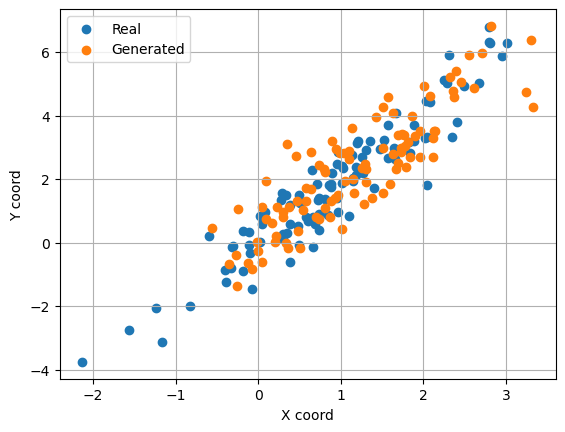

Generator vs Discriminator loss


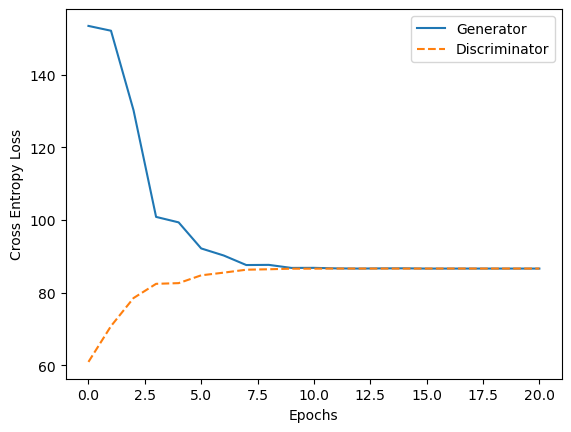

In [23]:

lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, train_dataloader, num_epochs, lr_D, lr_G,
latent_dim, data[:100].detach().numpy())